# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch

In [1]:
!nvidia-smi

Mon Apr 11 06:41:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# arff to pandas
!pip install -qq arff2pandas

In [3]:
#Setup Gdrive file download extention 
!conda install -y gdown

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    beautifulsoup4-4.11.1      |     pyha770c72_0          96 KB  conda-forge
    certifi-2021.10.8          |   py37h89c1867_2         145 KB  conda-forge
    conda-4.12.0               |   py37h89c1867_0         1.0 MB  conda-forge
    filelock-3.6.0             |     pyhd8ed1ab_0          12 KB  conda-forge
    gdown-4.4.0                |     pyhd8ed1ab_0          16 KB  conda-forge
    openssl-1.1.1n             |       h166bdaf_0         2.1 MB  conda-forge
    soupsieve-2.3.1            |     pyhd8ed1ab_0          33 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.4 MB

The following NEW packages will be INSTALLED:

  beautifu

In [4]:
import torch
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
from arff2pandas import a2p

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set(style= 'whitegrid', palette= 'muted', font_scale= 1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [5]:
!gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /kaggle/working/ECG5000.zip
100%|██████████████████████████████████████| 10.6M/10.6M [00:00<00:00, 42.5MB/s]


In [6]:
!unzip -qq ECG5000.zip

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # if gpu is available use gpu

In [8]:
# convert arff to pandas
with open('ECG5000_TRAIN.arff') as f:
  train = a2p.load(f)
with open('ECG5000_TEST.arff') as f:
  test = a2p.load(f)

In [9]:
train.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1


In [10]:
test.head()

,att1@NUMERIC,att2@NUMERIC,att3@NUMERIC,att4@NUMERIC,att5@NUMERIC,att6@NUMERIC,att7@NUMERIC,att8@NUMERIC,att9@NUMERIC,att10@NUMERIC,...,att132@NUMERIC,att133@NUMERIC,att134@NUMERIC,att135@NUMERIC,att136@NUMERIC,att137@NUMERIC,att138@NUMERIC,att139@NUMERIC,att140@NUMERIC,"target@{1,2,3,4,5}"
0,3.690844,0.711414,-2.114091,-4.141007,-4.574472,-3.431909,-1.950791,-1.107067,-0.632322,0.334577,...,0.022847,0.188937,0.480932,0.629250,0.577291,0.665527,1.035997,1.492287,-1.905073,1
1,-1.348132,-3.996038,-4.226750,-4.251187,-3.477953,-2.228422,-1.808488,-1.534242,-0.779861,-0.397999,...,1.570938,1.591394,1.549193,1.193077,0.515134,0.126274,0.267532,1.071148,-1.164009,1
2,1.024295,-0.590314,-1.916949,-2.806989,-3.527905,-3.638675,-2.779767,-2.019031,-1.980754,-1.440680,...,0.443502,0.827582,1.237007,1.235121,1.738103,1.800767,1.816301,1.473963,1.389767,1
3,0.545657,-1.014383,-2.316698,-3.634040,-4.196857,-3.758093,-3.194444,-2.221764,-1.588554,-1.202146,...,0.777530,1.119240,0.902984,0.554098,0.497053,0.418116,0.703108,1.064602,-0.044853,1
4,0.661133,-1.552471,-3.124641,-4.313351,-4.017042,-3.005993,-1.832411,-1.503886,-1.071705,-0.521316,...,1.280823,1.494315,1.618764,1.447449,1.238577,1.749692,1.986803,1.422756,-0.357784,1


In [11]:
df = train.append(test)
df = df.sample(frac=1.0)      # shuffling dataframe
df.shape

(5000, 141)

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

In [12]:
CLASS_NORMAL = 1

class_names = ['Normal', 'R on T', 'PVC', 'SP', 'UB']

## Data Preprocessing

In [13]:
#changing name of the target column

new_columns = list(df.columns)
new_columns[-1] = 'target'    
df.columns =new_columns
df.columns

Index(['att1@NUMERIC', 'att2@NUMERIC', 'att3@NUMERIC', 'att4@NUMERIC',
       'att5@NUMERIC', 'att6@NUMERIC', 'att7@NUMERIC', 'att8@NUMERIC',
       'att9@NUMERIC', 'att10@NUMERIC',
       ...
       'att132@NUMERIC', 'att133@NUMERIC', 'att134@NUMERIC', 'att135@NUMERIC',
       'att136@NUMERIC', 'att137@NUMERIC', 'att138@NUMERIC', 'att139@NUMERIC',
       'att140@NUMERIC', 'target'],
      dtype='object', length=141)

## Exploration

In [14]:
# total examples in each class
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'Normal'),
 Text(1, 0, 'R on T'),
 Text(2, 0, 'PVC'),
 Text(3, 0, 'SP'),
 Text(4, 0, 'UB')]

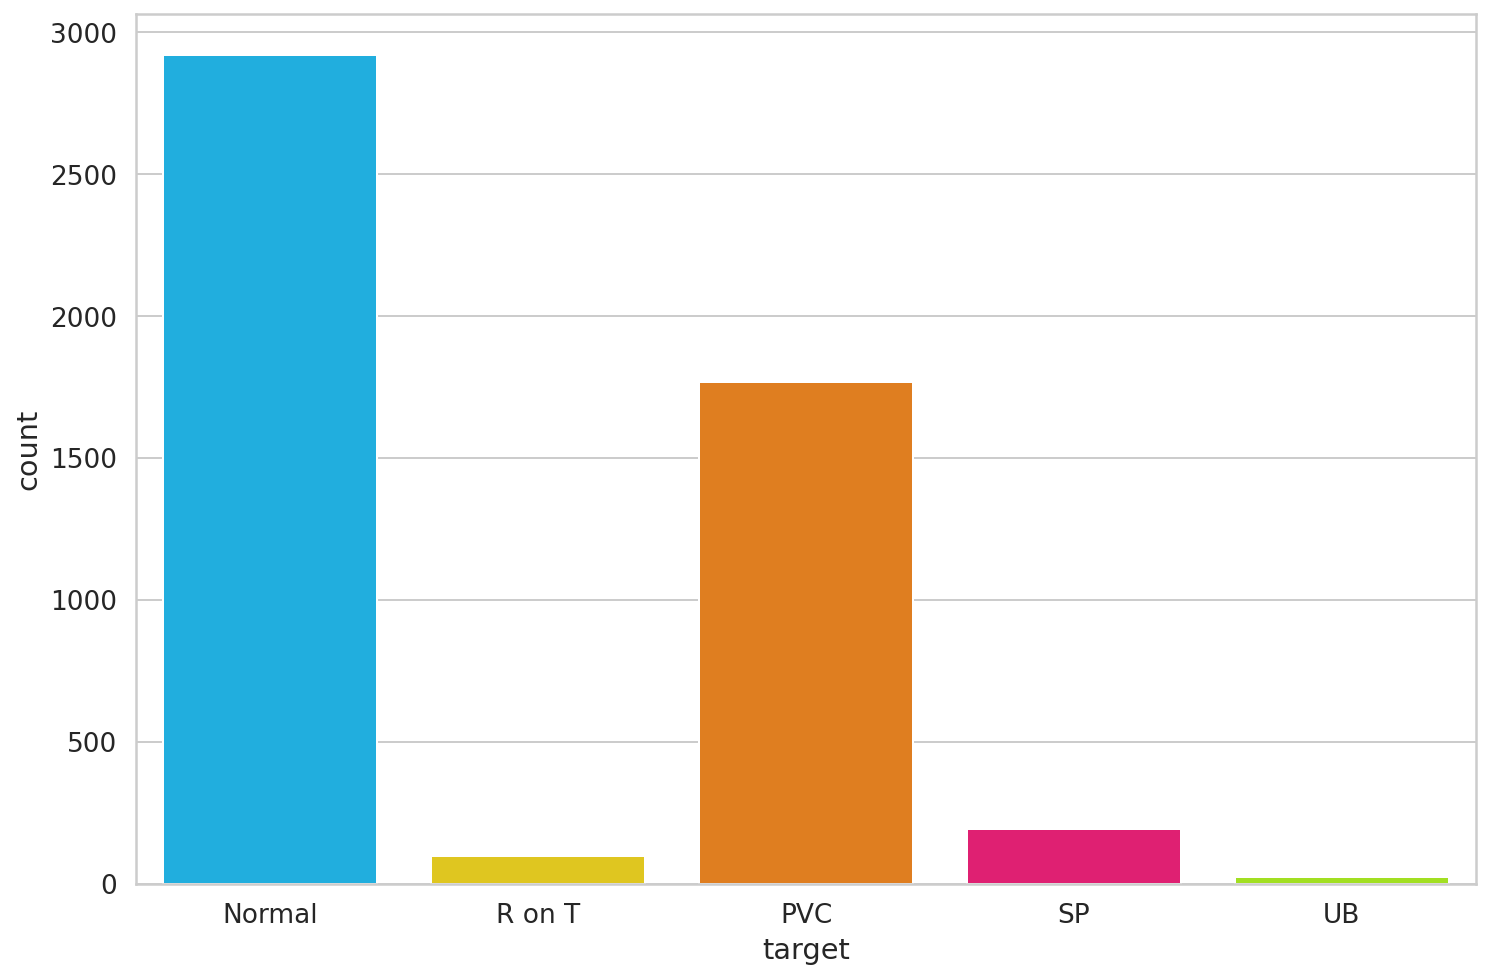

In [15]:
# checking class imbalance
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names)

In [16]:
# checking mean values of each class
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )                                             # standard deviation
  ax.set_title(class_name)

In [17]:
# mean value of each column
'''df[df.target == str(CLASS_NORMAL)] \
    .drop(labels = 'target', axis = 1) \
    .mean(axis = 0).shape'''

"df[df.target == str(CLASS_NORMAL)]     .drop(labels = 'target', axis = 1)     .mean(axis = 0).shape"

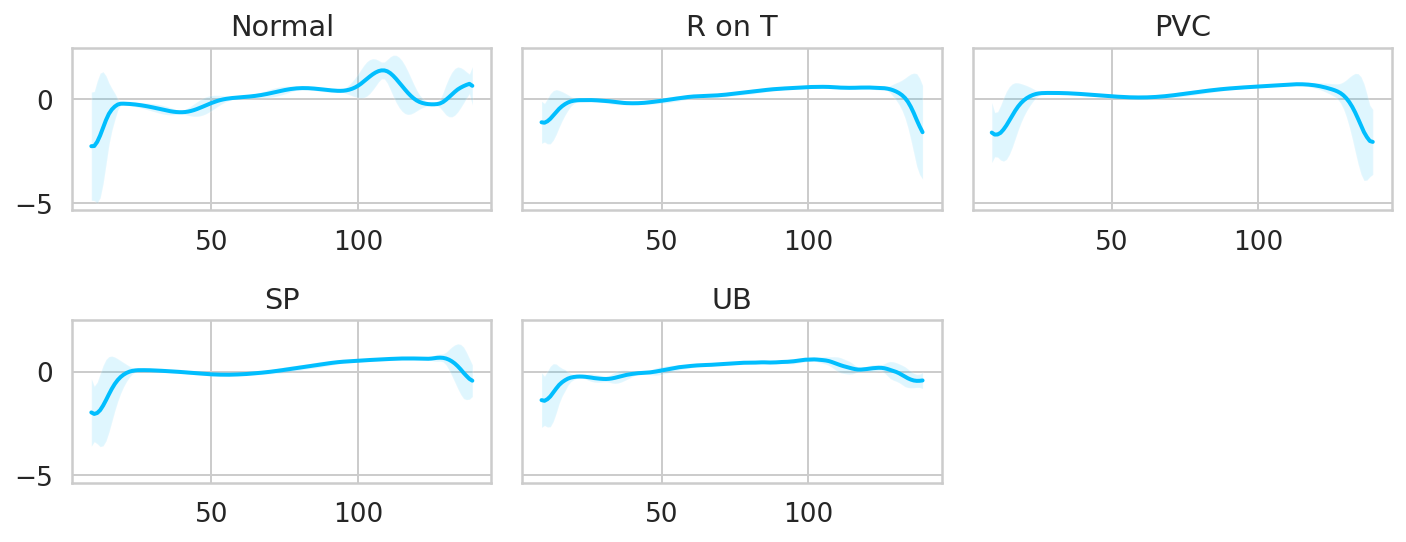

In [18]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(10, 4)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()                         # taking mean value for each column by axis = 0
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])               # deleting last axis cause we only have 5 classes
fig.tight_layout();

Less opacity areas denote standard deviation from the mean values.

## Data Preprocessing

Getting all normal heartbeats and dropping the target (class) column:

In [19]:
normal_df = df[df.target == str(CLASS_NORMAL)].drop(labels='target', axis = 1)
normal_df.shape

(2919, 140)

Merging all other classes and mark them as anomalies ; dropping labels:

In [20]:
anomaly_df = df[df.target != str(CLASS_NORMAL)].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

Splitting the normal examples into train, validation and test sets:

In [21]:
# shuffling not needed, did already

# splitting normal dataset to train & val
train_df, val_df = train_test_split(normal_df, test_size=0.15, random_state= RANDOM_SEED)

# splitting val dataframe to val & test
val_df, test_df = train_test_split(val_df, test_size=0.5, random_state= RANDOM_SEED)

In [22]:
test_df.shape

(219, 140)

In [23]:
# list of np arrays 
train_sequences = train_df.astype(np.float32).to_numpy().tolist()
val_sequences = val_df.astype(np.float32).to_numpy().tolist()
test_sequences = test_df.astype(np.float32).to_numpy().tolist()
anomaly_sequences = anomaly_df.astype(np.float32).to_numpy().tolist()

Need to convert the examples into tensors, so we can use them to train our Autoencoder. The helper function for that:

In [24]:
# converting sequences to torch tensors
# training model single example at a time so that batch size is 1

def create_dataset(sequences):
  
  dataset = [torch.tensor(s).unsqueeze(1) for s in sequences] # converting each sequence to a tensor & adding a dimension

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Creating some datasets:

In [25]:
# creating tensors

train_dataset, seq_len, n_features = create_dataset(train_sequences)

val_dataset, seq_len, n_features = create_dataset(val_sequences)

test_dataset, seq_len, n_features = create_dataset(test_sequences)

test_anomaly_dataset, seq_len, n_features = create_dataset(anomaly_sequences)

## Building an LSTM Autoencoder
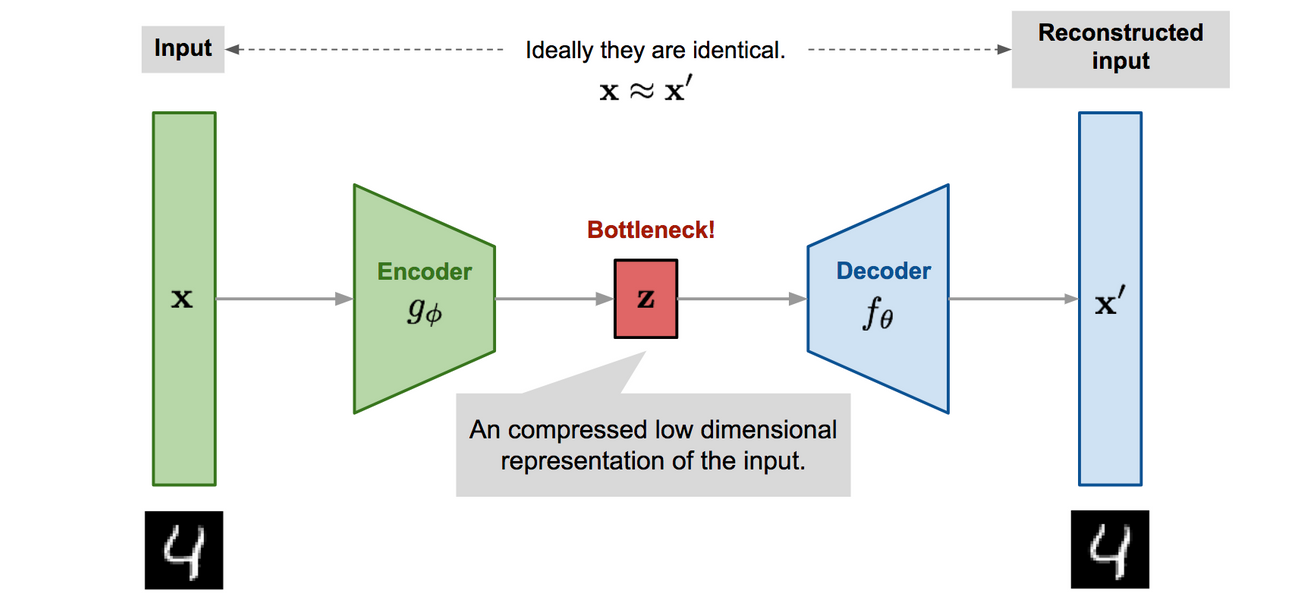

The general Autoencoder architecture consists of two components. An Encoder that compresses the input and a Decoder that tries to reconstruct it.

Autoencoder's job is to learn the pattern from data. This is learned by learning how to represent the data using some lowering of the dimensionality of the data. Autoencoder compresses and reconstructs the data.

* We will train on normal heartbeats, 
autoencoder understands how normal heartbeats look like. 
* Then we pass heartbeats with anomalies, autoencoder will not be able to reconstruct those data. 
* We can measure the reconstruction error then, when the error is high, we can tell there is an anomaly.

> **Reconstruction error** 
tells how well the data is understood by autoencoder.


Using the LSTM Autoencoder from [this](https://github.com/shobrook/sequitur) GitHub repo with some small tweaks. The model’s job is to reconstruct Time Series data. 

In [26]:
# using Recurrent Autoencoder and tweaking with a linear layer into the decoder

class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))   # (batch_size, seq_len, num of features)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))  # num of units/neurons into the hidden layer

The Encoder uses two LSTM layers to compress the Time Series data input.

Decoding the compressed representation using a Decoder:

In [27]:
# passing in results from the encoder

class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    # outputting univariate time series with 140 predictions
    self.output_layer = nn.Linear(self.hidden_dim, n_features)  # dense output layer; contains 140 examples

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))    # reshaping

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

The Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Wrapping everything into an easy to use module:

In [28]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [29]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)        # moving model to gpu

## Training

In [30]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)     # summing error; L1Loss = mean absolute error in torch
  
  history = dict(train=[], val=[])                      # recording loss history

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []

    for seq_true in train_dataset:     # iterate over each seq for train data
      optimizer.zero_grad()            # no accumulation

      seq_true = seq_true.to(device)   # putting sequence to gpu
      seq_pred = model(seq_true)       # prediction

      loss = criterion(seq_pred, seq_true)  # measuring error

      loss.backward()                  # backprop
      optimizer.step()

      train_losses.append(loss.item())  # record loss by adding to training losses

    val_losses = []
    model = model.eval()
    with torch.no_grad():  # requesting pytorch to record any gradient for this block of code
      for seq_true in val_dataset:
          seq_true = seq_true.to(device)   # putting sequence to gpu
          seq_pred = model(seq_true)       # prediction

          loss = criterion(seq_pred, seq_true)  # recording loss

          val_losses.append(loss.item())    # storing loss into the validation losses
    train_loss = np.mean(train_losses)   # computing loss on training and val data for this epoch
    val_loss = np.mean(val_losses)
    history['train'].append(train_loss)
    history['val'].append(val_loss)

    print(f'Epoch {epoch}: train loss = {train_loss}, val loss = {val_loss}')

  return model.eval(), history      # after training, returning model to evaluation mode

In [31]:
model, history = train_model(model, train_dataset, val_dataset, n_epochs= 150)

Epoch 1: train loss = 66.83343542145894, val loss = 55.525589598912624
Epoch 2: train loss = 55.20931845084163, val loss = 54.61461249225216
Epoch 3: train loss = 54.68910345594905, val loss = 51.194640364276765
Epoch 4: train loss = 51.26119209806173, val loss = 49.617888707548516
Epoch 5: train loss = 50.19634951030665, val loss = 50.472771527016
Epoch 6: train loss = 48.1297771741382, val loss = 47.44541983408471
Epoch 7: train loss = 46.725867035022816, val loss = 45.600984782388764
Epoch 8: train loss = 44.19987251776834, val loss = 37.16617766254024
Epoch 9: train loss = 31.424432686479378, val loss = 26.56671441308984
Epoch 10: train loss = 28.054747998546276, val loss = 29.96348756415659
Epoch 11: train loss = 26.909910494932383, val loss = 26.921540726265405
Epoch 12: train loss = 26.628112633446445, val loss = 24.15653669017635
Epoch 13: train loss = 25.915711294879166, val loss = 26.707239569049992
Epoch 14: train loss = 25.261104545685516, val loss = 22.5381356722688
Epoch 

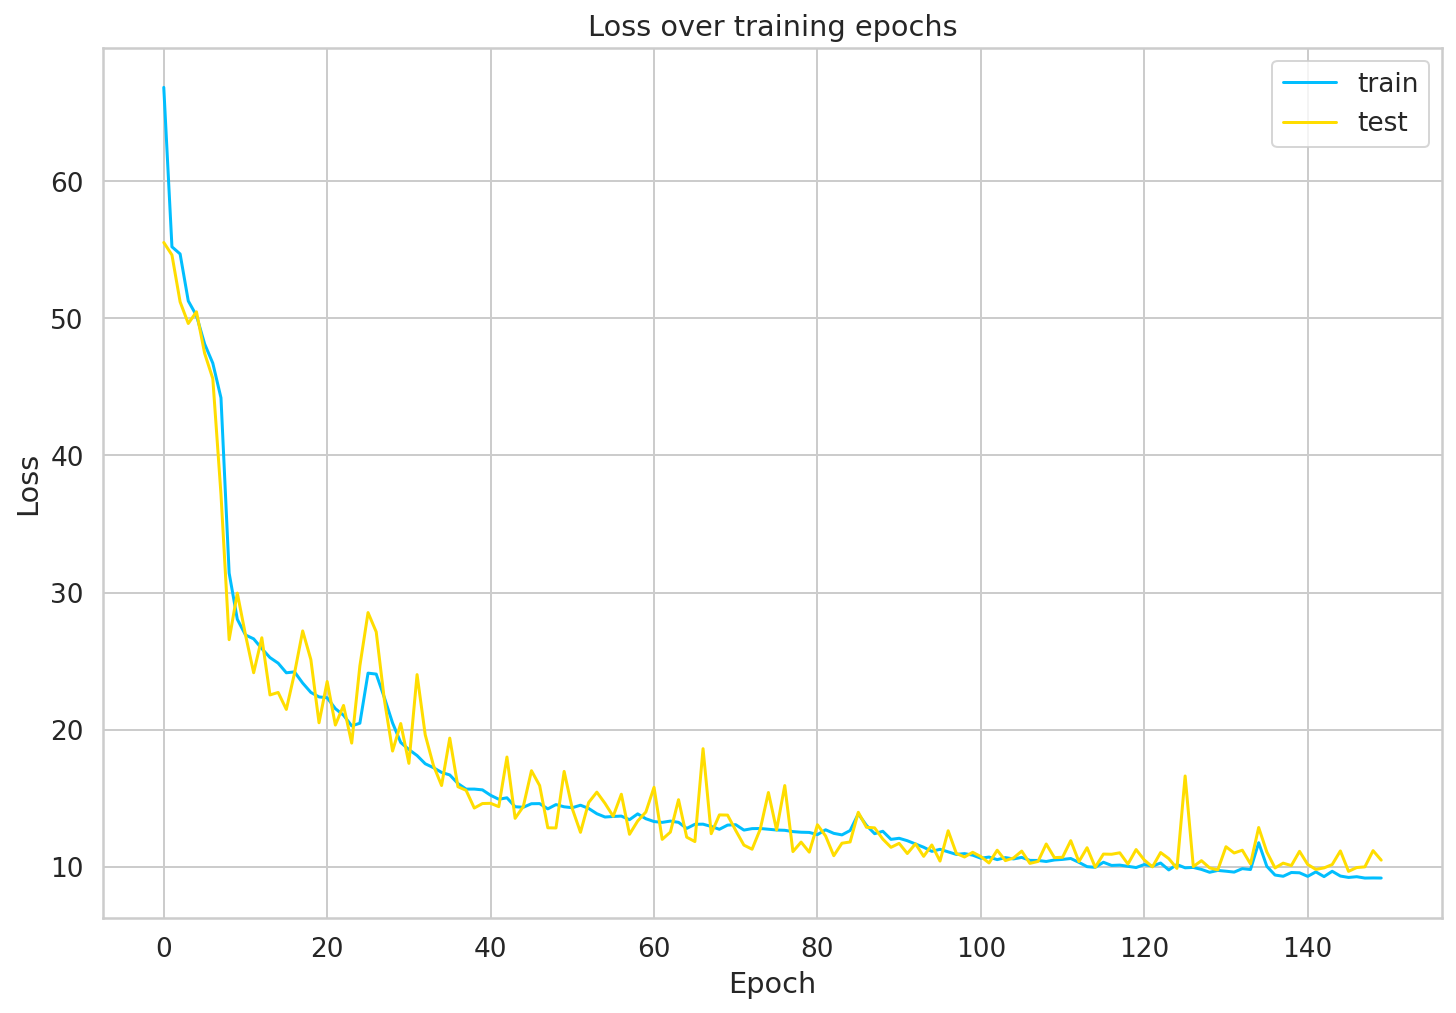

In [32]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

## Saving the model

In [37]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

In [34]:
# loading pre-trained model from checkpoint

# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

Writing a helper function to get predictions from our model

In [35]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction = 'sum').to(device) #L1 to gpu

  with torch.no_grad():
    model = model.eval()      # putting in evaluation mode          
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)  # calculating loss
      
      predictions.append(seq_pred.cpu().numpy().flatten()) # appending predictions & loss to results 
      losses.append(loss.item())
  return predictions, losses


In [ ]:
_, losses = predict(model, train_dataset)

In [ ]:
sns.distplot(losses, bins= 50, kde= True)